Imports

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import multiprocessing
import scipy.ndimage
import skimage
import sklearn.cluster
import scipy.spatial.distance
import os, time
import matplotlib.pyplot as plt
import random
from skimage import io
from keras.datasets import mnist 

Pre-processing [for Mnist dataset](https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/)

11501568/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


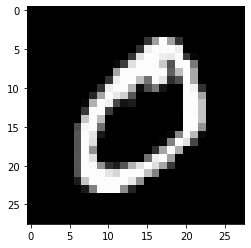

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)
img = datagen.standardize(X_train[1])
operatedImage = np.float32(img) / 255
plt.imshow(operatedImage,cmap='gray')

# Feature extraction

Harris corner detector

In [3]:
def get_harris_points(operatedImage):
  dest = cv2.cornerHarris(operatedImage, 2, 3, 0.04)
  dest = cv2.dilate(dest, None)
  HarrisImage = np.copy(operatedImage)
  HarrisImage = np.stack((HarrisImage, HarrisImage, HarrisImage), axis=-1)
  HarrisImage[abs(dest) > 0.05 * dest.max()] = [255,0,0]
  harris_points = list(np.where(abs(dest) > 0.05 * dest.max()))
  return harris_points

filter responses

In [4]:
def display_filter_responses(response_maps):
    '''
    Visualizes the filter response maps.

    [input]
    * response_maps: a numpy.ndarray of shape (H, W, 3F)
    '''

    fig = plt.figure(1)

    for i in range(20):
        plt.subplot(5, 4, i+1)
        resp = response_maps[:, :, i]
        resp_min = resp.min(axis=(0, 1), keepdims=True)
        resp_max = resp.max(axis=(0, 1), keepdims=True)
        resp = (resp-resp_min)/(resp_max-resp_min)
        plt.imshow(resp, cmap = 'gray')
        plt.axis("off")

    plt.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.05,wspace=0.05,hspace=0.05)
    plt.show()

Applying different filers on images for edge calculation

In [7]:
def extract_filter_responses(image):
    '''
    Extracts the filter responses for the given image.

    [input]
    * image: numpy.ndarray of shape (H, W) 

    [output]
    * filter_responses: numpy.ndarray of shape (H, W, F)
    '''

    image = image.astype('float')
    image[image<0.5] = 0
    filter_responses = []
    
    for scale in [1,2,4,8,8*np.sqrt(2)]:
        #(1) Gaussian, (2) Laplacian of Gaussian, (3) derivative of Gaussian in the  𝑥  direction, and (4) derivative of Gaussian in the  𝑦  direction.
        r = scipy.ndimage.gaussian_filter(image,scale)
        gaussian = np.dstack([r])
        
        r = scipy.ndimage.gaussian_laplace(image,scale)
        laplace = np.dstack([r])
        
        r = scipy.ndimage.filters.gaussian_filter(image,(scale,scale),(1,0))
        y_dir = np.dstack([r])

        r = scipy.ndimage.filters.gaussian_filter(image,(scale,scale),(0,1))
        x_dir = np.dstack([r])
        
        if len(filter_responses) != 0:
            filter_responses = np.dstack([filter_responses, gaussian,laplace,x_dir,y_dir])
        else:
            filter_responses = np.dstack([gaussian,laplace,x_dir,y_dir])
    return filter_responses 

Compare the image with filter responses and detect the common edge points

In [8]:
def compute_dictionary_one_image(args):
    '''
    Extracts samples of the dictionary entries from an image. Use the the 
    harris corner detector implmented from previous question to extract 
    the point of interests. This should be a function run by a subprocess.

    [input]
    * i: index of training image
    * image_path: image

    [saved]
    * sampled_response: numpy.ndarray of shape (alpha, 3F)
    '''
    i, image = args
    if not os.path.isdir('tmp'):
        os.mkdir('tmp')

    f_name = 'tmp/%05d.npy' % i

    harris_points = get_harris_points(image)
    filter_responses = extract_filter_responses(image)
    sampled_responses = np.zeros(( len(harris_points[0]),filter_responses.shape[2] ))

    for i in range(len(harris_points[0])):
        y,x = harris_points[0][i], harris_points[1][i]
        for n in range(filter_responses.shape[2]):
            sampled_responses[i,n] = filter_responses[y,x,n]
    np.save(f_name,sampled_responses)

---

Training dataset processing


---



In [9]:
def compute_dictionary(num_workers=2):
    '''
    Creates the dictionary of visual words by clustering using k-means.

    [input]
    * num_workers: number of workers to process in parallel

    [saved]
    * dictionary: numpy.ndarray of shape (K,F)
    '''
    # ----- TODO -----
    list_of_args = []

    n_clusters = 50


    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    num_images = len(X_train)
    datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)

    for i in range(num_images):
        img = datagen.standardize(X_train[i])
        operatedImage = np.float32(img) / 255
        list_of_args.append([i, X_train[i]])

    with multiprocessing.Pool(num_workers) as p:
        p.map(compute_dictionary_one_image, list_of_args)

    filter_responses = []
    for file_name in os.listdir('./tmp'):
        cur = np.load('./tmp/'+file_name)
        if len(filter_responses) == 0:
            filter_responses = cur
        else:
            filter_responses = np.vstack([filter_responses,cur])

    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(filter_responses)
    dictionary = kmeans.cluster_centers_ 
    np.save('dictionary.npy', dictionary)

In [ ]:
compute_dictionary()

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
